In [118]:
import createdb as cdb
import detectobjects as det
import convnet
import numpy as np
import subprocess
import seaborn as sns
import pylab as plt
import lmdb

from sklearn import ensemble, neighbors, metrics
%matplotlib inline

In [4]:
opts = {'img_dir': '../data/images/',
        'models_dir': '../models/',
        'annotation_dir': '../data/annotation/',
        'train-dir': '../data/train/',
        'test-dir': '../data/test/',
        'val-dir': '../data/val/',
        'augment-training-data': False,
        'model': '2C-1FC-O',
        'threshold': 0.1, 
        'overlapThreshold': 0.3, 
        'lim': 0, 
        'prob': det.MAX, 
        'pos': det.MAX, 
        'gauss': 1,
        'mean': np.array([162.83]),
        'input_scale': None,
        'raw_scale': 255,
        'image_dims': (50,50),
        'channel_swap': None,
        'probs_area': 40,
        'detection-step': 5,
        'patch-creation-step': 40,
       }

**Create and load data files**

In [166]:
# Divide images into training, validation and testing sets
trainfiles, valfiles, testfiles = cdb.create_sets(opts['img_dir'], train_set_proportion=.6, 
                                                  test_set_proportion=.2,
                                                  val_set_proportion=.2)

# Write training, validation and test data for file, if not already done
#cdb.write_db(trainfiles, valfiles, testfiles, opts)

In [ ]:
# Load training and validation data from database
X_train, y_train = cdb.load_db(opts['train-dir'])
X_val, y_val =  cdb.load_db(opts['val-dir'])

**Detector training**

In [170]:
clf = ensemble.ExtraTreesClassifier(n_estimators=200, n_jobs=7)
clf.fit(X_train,y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=7,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

**Evaluate performance on test set**

In [171]:
reload(det)
found_objects = {}
N = len(testfiles)
for i, f in zip(range(N), testfiles):
    print '%d/%d %s' % (i+1,N,f)
    imfile = opts['img_dir'] + f
    found = det.detect(imfile, clf, opts)
    found_objects[f] = found

1/541 plasmodium-0236.jpg
2/541 plasmodium-1600.jpg
3/541 plasmodium-1985.jpg
4/541 plasmodium-1308.jpg
5/541 plasmodium-0249.jpg
6/541 plasmodium-1006.jpg
7/541 plasmodium-1164.jpg
8/541 plasmodium-2626.jpg
9/541 plasmodium-1315.jpg
10/541 plasmodium-1259.jpg
11/541 plasmodium-0609.jpg
12/541 plasmodium-0642.jpg
13/541 plasmodium-2224.jpg
14/541 plasmodium-2618.jpg
15/541 plasmodium-0046.jpg
16/541 plasmodium-0531.jpg
17/541 plasmodium-0548.jpg
18/541 plasmodium-1833.jpg
19/541 plasmodium-0995.jpg
20/541 plasmodium-0630.jpg
21/541 plasmodium-0394.jpg
22/541 plasmodium-0956.jpg
23/541 plasmodium-1688.jpg
24/541 plasmodium-2134.jpg
25/541 plasmodium-0305.jpg
26/541 plasmodium-1153.jpg
27/541 plasmodium-2323.jpg
28/541 plasmodium-0908.jpg
29/541 plasmodium-0062.jpg
30/541 plasmodium-0907.jpg
31/541 plasmodium-0823.jpg
32/541 plasmodium-1415.jpg
33/541 plasmodium-2141.jpg
34/541 plasmodium-2030.jpg
35/541 plasmodium-1418.jpg
36/541 plasmodium-0033.jpg
37/541 plasmodium-1339.jpg
38/541 pla

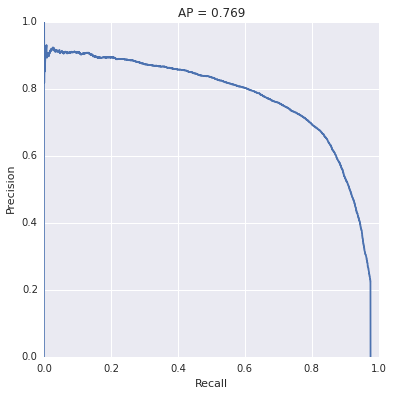

In [172]:
import evaluation as ev
found_dict = found_objects
rec, prec, p = ev.evaluate_detection(found_dict, opts['annotation_dir'],testfiles,0.15)
area = ev.compute_auc(rec, prec)        

current_palette = sns.color_palette()
fig,ax = plt.subplots()
fig.set_size_inches(6,6)        
sns.set_style("darkgrid")
plt.plot(np.hstack([0,rec,rec[-1]]),
            np.hstack([0,prec,0]) , color=current_palette[0])
plt.xlabel('Recall')
plt.ylabel('Precision')      
plt.grid(True)        
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title("AP = " + "{:0.3f}".format(area))